# Tópico 17 - Trabalho final da disciplina (Aplicação de DSP Áudio ou Imagem)

Aplicação de Processamento Digital de Sinais (DSP) em Sonar do Tipo *Echosounder* para Detecção de Profundidade do Fundo e Realização de Batimetria

## Alunos

* Alejo Perdomo Milar
* João Mário C. I. Lago

# Contexto

Este trabalho aborda a aplicação de Processamento Digital de Sinais (DSP) em um sonar do tipo *Echosounder* para a detecção da profundidade do fundo de rios, lagos ou mares com finalidade batimétrica. Discute-se o tratamento do sinal recebido e os métodos utilizados para estimar a profundidade. O trabalho apresenta a fundamentação teórica, a implementação em código Python e a posterior otimização para um microcontrolador STM32F303RETx (Cortex-M4), utilizando intrínsecas e técnicas SIMD para execução paralela.

No contexto moderno, existem diversas tecnicas de compressão de pulso que sonares podem utilizar para aumentar a sua resolução de range, porém o trabalho a seguir irá apresentar a implementação mais simples e comunmente usada em sonares de baixo custo que consiste em um pulso de frequencia unica e a detecção de tempo de voo do echo de forma simples utilizando apenas filtros simples (passa faixa e passa baixa) sem técnincas mais avançadas de compressão de pulso ou filtros casados.

# Fundamentação

## Sequência de transmissão e eco

<div style="display: flex; justify-content: center;">
    <img src="./assets/application-overview.drawio.png" height="420" alt="Visão geral da transmissão e recepção do pulso sonar">
</div>

## Perfil temporal do sinal

<div style="display: flex; justify-content: center;">
    <img src="./assets/typical-profile.drawio.png" height="420" alt="Perfil temporal típico do sinal transmitido e do eco">
</div>

## Arquitetura de referência


<div style="display: flex; justify-content: center;">
    <img src="./assets/sonar-overview.drawio.png" height="420" alt="Arquitetura completa do echosounder">
</div>

## Objetivo do documento



# Implementação Python

Primeiramente será realizado uma implementação dos processos mencionados acima em python para se facilitar a compreensão dos processos que deseja-se atingir e posteriormente será realizado o port para um código C em especifico otimizando para utilização de intrínsecas e técnicas SIMD para um cortex M4.

## Blibliotecas e imports

In [245]:
%pip install -q numpy matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [246]:
import numpy as np
import matplotlib.pyplot as plt

## Sinal original

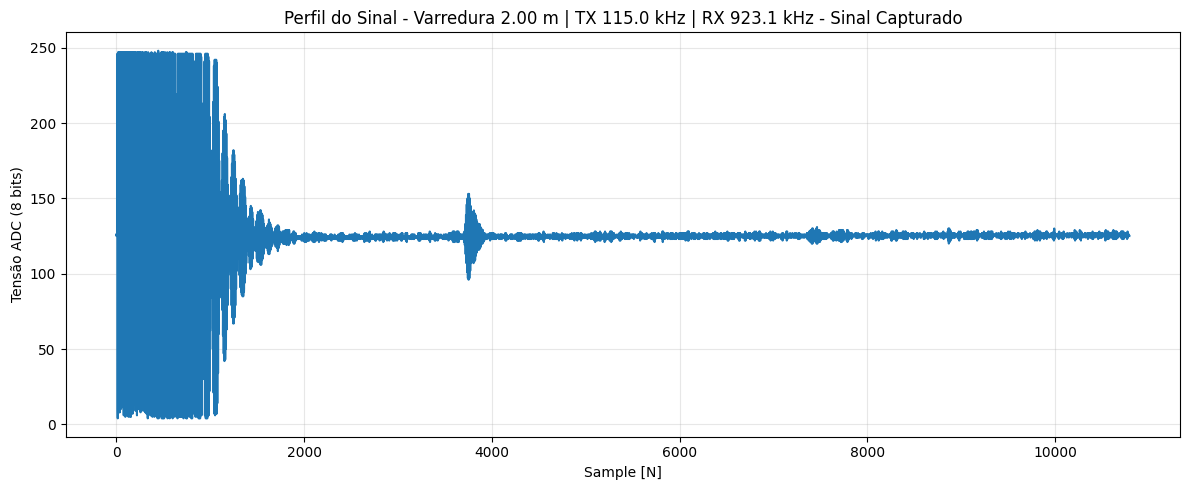

In [247]:
from assets.sample import (
    data as raw_adc_data,
    scan_length_mm,
    tx_freq,
    rx_sampling_freq,
    speed_of_sound,
)

# Converte os valores carregados para float e evita alterar a lista original fornecida pelos assets
signal_samples = [float(sample) for sample in raw_adc_data]

# Texto padrão utilizado em todos os gráficos desta análise
BASE_PLOT_TITLE = (
    f"Perfil do Sinal - Varredura {scan_length_mm / 1000:.2f} m | "
    f"TX {tx_freq / 1000:.1f} kHz | RX {rx_sampling_freq / 1000:.1f} kHz"
)


def plot_signal(
    samples,
    *,
    overlay=None,
    overlay_labels=None,
    vertical_marker=None,
    horizontal_marker=None,
    title_suffix="",
    main_label=None,
):
    """Gera gráficos padronizados para o sinal e camadas auxiliares."""
    plt.figure(figsize=(12, 5))

    if main_label:
        plt.plot(samples, label=main_label)
    else:
        plt.plot(samples)

    if overlay:
        labels = overlay_labels or [None] * len(overlay)
        for extra_series, extra_label in zip(overlay, labels):
            plt.plot(extra_series, label=extra_label)

    if vertical_marker is not None:
        plt.axvline(
            x=vertical_marker,
            color="r",
            linestyle="--",
            label="Marcador Vertical",
        )

    if horizontal_marker is not None:
        plt.axhline(
            y=horizontal_marker,
            color="r",
            linestyle="--",
            label="Marcador Horizontal",
        )

    plt.title(f"{BASE_PLOT_TITLE}{title_suffix}")
    plt.xlabel("Sample [N]")
    plt.ylabel("Tensão ADC (8 bits)")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    legend_needed = any(
        [
            main_label,
            overlay and any(overlay_labels or []),
            vertical_marker is not None,
            horizontal_marker is not None,
        ]
    )
    if legend_needed:
        plt.legend()

    plt.show()

# Visualiza o sinal bruto antes de qualquer transformação
plot_signal(signal_samples, title_suffix=" - Sinal Capturado")


## Retificação

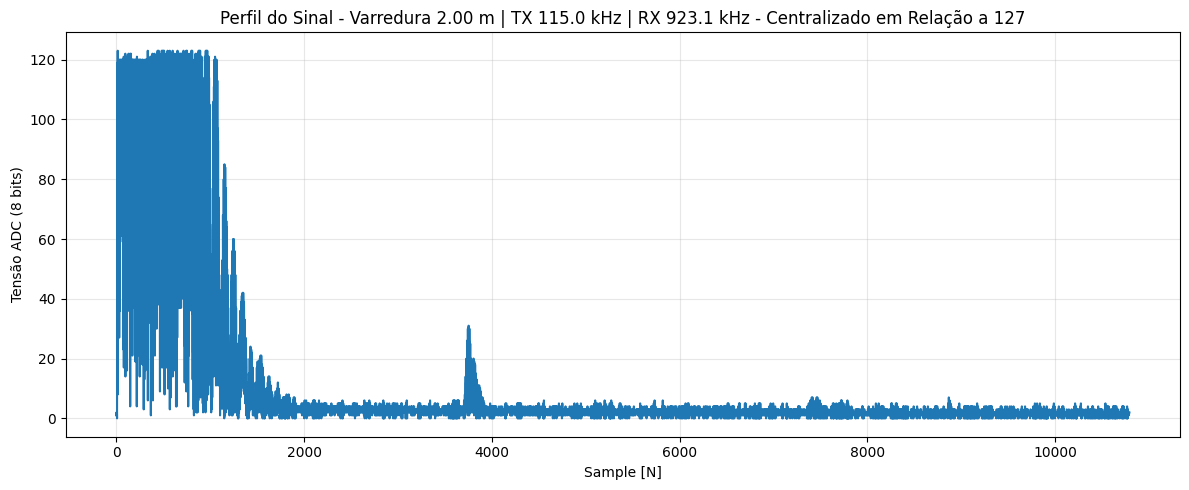

In [248]:
# Centraliza o sinal em torno de 127 para remover o offset do ADC
for index, value in enumerate(signal_samples):
    if value >= 127:
        signal_samples[index] = value - 127
    else:
        signal_samples[index] = 127 - value

plot_signal(
    signal_samples,
    title_suffix=" - Centralizado em Relação a 127",
)


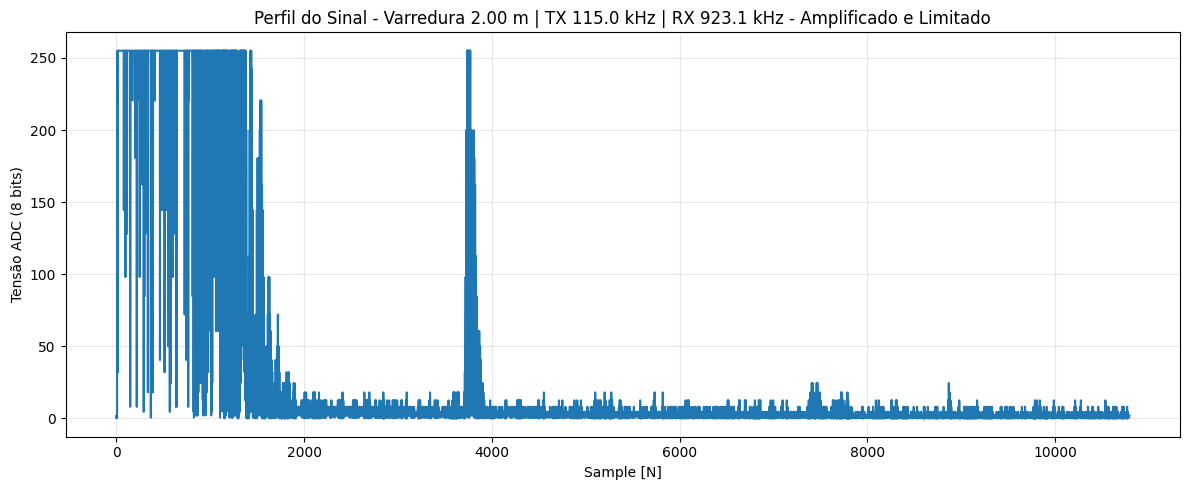

In [249]:
# Amplifica o conteúdo útil e aplica saturação para manter o sinal em 8 bits
for index, value in enumerate(signal_samples):
    amplified_value = value * (value / 2.0)
    signal_samples[index] = min(amplified_value, 255)

plot_signal(
    signal_samples,
    title_suffix=" - Amplificado e Limitado",
)


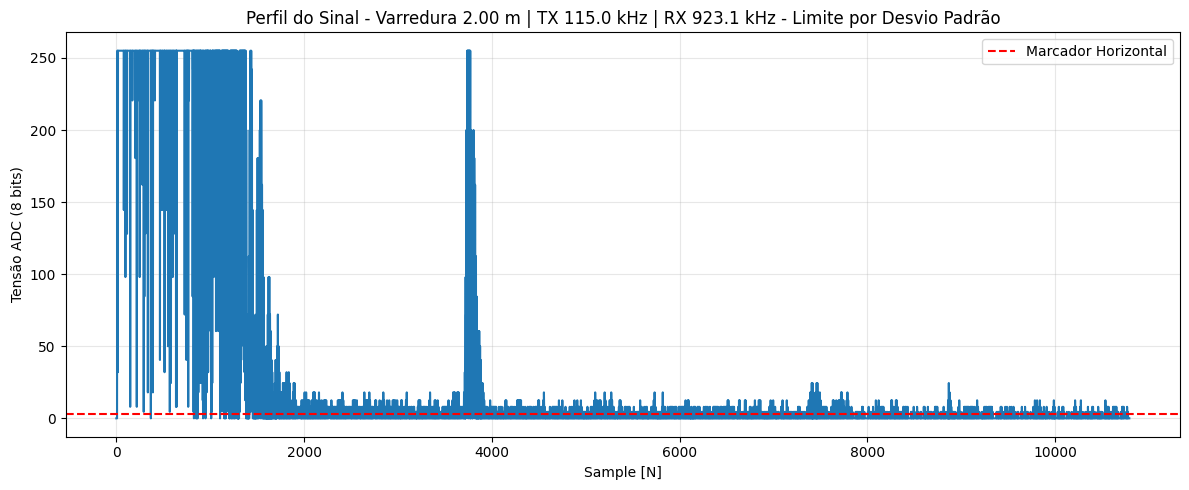

In [250]:
# Calcula o desvio padrão da metade final para identificar o piso de ruído
signal_tail = signal_samples[len(signal_samples) // 2 :]
tail_std_dev = np.std(signal_tail)

# Mantém apenas valores acima do desvio padrão calculado
for index, value in enumerate(signal_samples):
    signal_samples[index] = value if value > tail_std_dev else 0

plot_signal(
    signal_samples,
    horizontal_marker=tail_std_dev,
    title_suffix=" - Limite por Desvio Padrão",
)


Intervalo entre amostras: 1.08 us


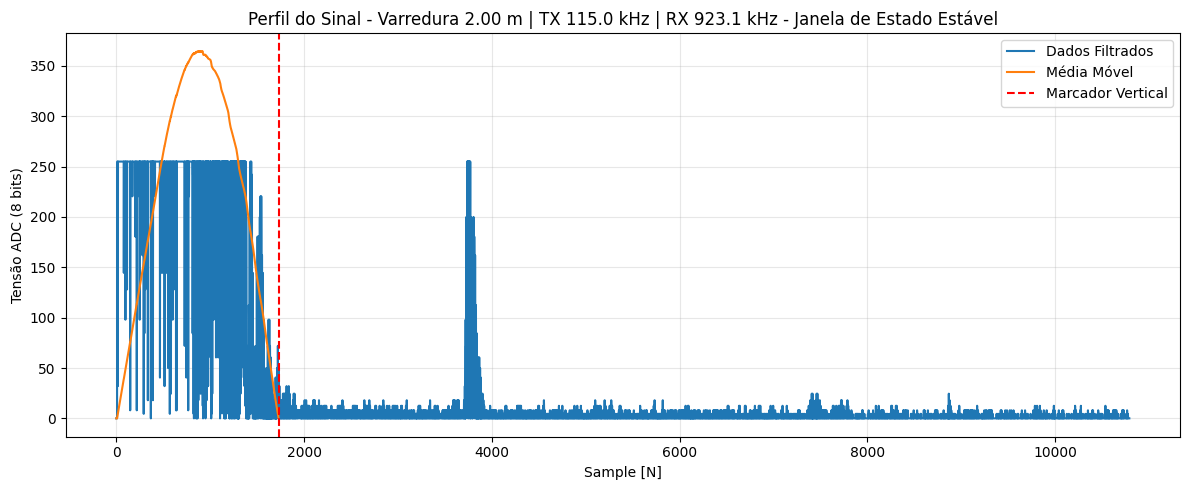

In [251]:
# Define a janela desejada (500 us) e calcula o intervalo entre amostras
sample_interval_us = (1.0 / float(rx_sampling_freq)) * 1e6
print(f"Intervalo entre amostras: {sample_interval_us:.2f} us")
steady_state_window_samples = int(500.0 / sample_interval_us)

# Usa o desvio padrão (com mínimo 5) como limiar para detectar o fim do transiente
steady_state_threshold = tail_std_dev if tail_std_dev > 5 else 5

moving_average_values = []
window_accumulator = 0.0
steady_state_end_index = 0

# Inicializa a soma da primeira janela
for i in range(steady_state_window_samples):
    window_accumulator += signal_samples[i]
    moving_average_values.append(window_accumulator / steady_state_window_samples)

# Desliza a janela e para quando a energia cai abaixo do limiar
for i in range(
    steady_state_window_samples,
    len(signal_samples) - steady_state_window_samples,
):
    window_accumulator -= moving_average_values[i - steady_state_window_samples]
    window_accumulator += signal_samples[i]

    if window_accumulator < steady_state_threshold:
        steady_state_end_index = i
        break

    moving_average_values.append(window_accumulator / steady_state_window_samples)

plot_signal(
    signal_samples,
    overlay=[moving_average_values],
    overlay_labels=["Média Móvel"],
    vertical_marker=steady_state_end_index,
    title_suffix=" - Janela de Estado Estável",
    main_label="Dados Filtrados",
)


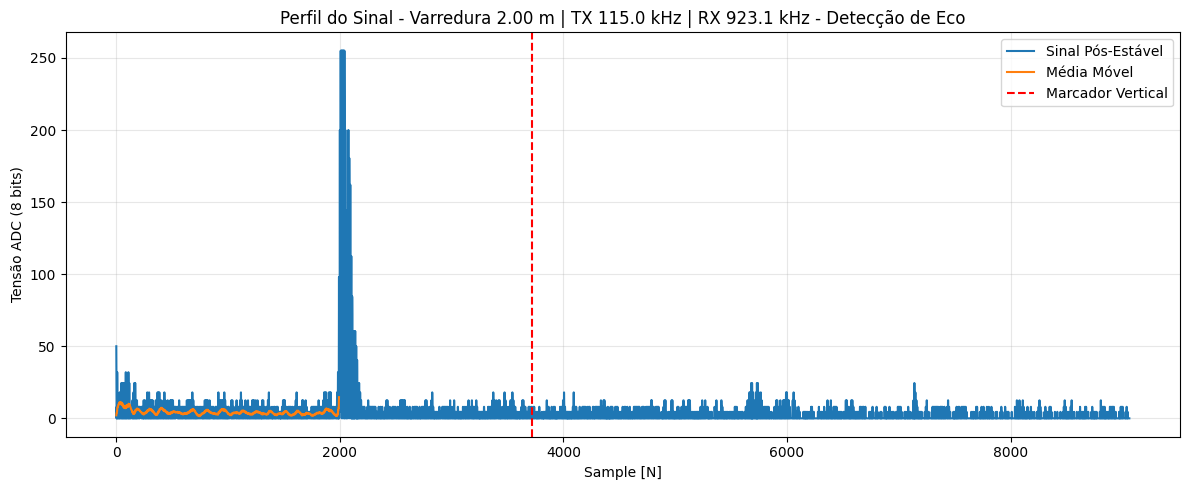

In [252]:
# Descarta o trecho anterior ao fim do estado transitório
signal_samples = signal_samples[steady_state_end_index:]

# Configura a janela de 350 us para encontrar ecos significativos
echo_window_size = 24

echo_threshold = 15 * echo_window_size

echo_window_values = []
echo_window_accumulator = 0.0
echo_index = 0

# Inicializa a média móvel da nova janela
for i in range(echo_window_size):
    echo_window_accumulator += signal_samples[i]
    echo_window_values.append(echo_window_accumulator / echo_window_size)

# Desliza a janela e registra o primeiro pico acima do limiar
for i in range(echo_window_size, len(signal_samples) - echo_window_size):
    echo_window_accumulator -= echo_window_values[i - echo_window_size]
    echo_window_accumulator += signal_samples[i]

    if echo_window_accumulator > echo_threshold:
        echo_index = i + steady_state_end_index
        break

    echo_window_values.append(echo_window_accumulator / echo_window_size)

plot_signal(
    signal_samples,
    overlay=[echo_window_values],
    overlay_labels=["Média Móvel"],
    vertical_marker=echo_index,
    title_suffix=" - Detecção de Eco",
    main_label="Sinal Pós-Estável",
)


In [253]:
mm_per_sample_point = ((1.0 / rx_sampling_freq) * speed_of_sound) / 2.0

depth_mm = mm_per_sample_point * echo_index
confidence = (1.0 - (tail_std_dev / 255.0)) * 100.0

print(f"Profundidade estimada: {depth_mm / 1e3:.2f} m")
print(f"Confiança: {confidence:.2f}%")

Profundidade estimada: 0.69 m
Confiança: 98.90%


# Algorítimo C

```cpp
void PingSonar::processProfile()
{
  /** Start cleaning buffer and preparing for search algorithms */

  /** We aim for around 350 us for the steady state window */
  uint16_t steady_state_window_size = (uint16_t)(350.0f / _sampleInterval);
  steady_state_window_size = (steady_state_window_size >> 3U) << 3U;

  /** Center based absolute difference to convert offset AC to pulsed DC */
  u8_fast_abs_delta(_DMABufferADC4, _sampleCycles, __U32_127);

  /** Amplify differences using half square */
  if (_isProfileEnhanced) {
    u8_fast_half_square(_DMABufferADC4, _sampleCycles);
  }

  /** Usually will never be needed bu if the data does not uses the whole range scale it */
  if (_isProfileNormalized) {
    uint8_t max = u8_fast_max(_DMABufferADC4, _sampleCycles);

    if (max < 255U) {
      u8_fast_normalize(_DMABufferADC4, _sampleCycles, max);
    }
  }

  /** Extract statistical data and verifies if it is usable */
  uint16_t half_buffer_size = _sampleCycles >> 1U;
  uint8_t mean = u8_fast_mean(&_DMABufferADC4[half_buffer_size], half_buffer_size);
  uint8_t std_dev = u8_fast_std_dev(&_DMABufferADC4[half_buffer_size], half_buffer_size, mean);

  /** Clean the thrash and make it easy for the searches */
  if (_isProfileEnhanced) {
    u8_fast_threshold_cut(_DMABufferADC4, _sampleCycles, _U32_PACK(std_dev));
  }

  /** Finds where the Piezo relaxed and stopped blinding us */
  uint8_t steady_finder_threshold = (std_dev > 10U) ? std_dev : 10U;
  uint16_t steady_state_index = steady_state_finder(
    _DMABufferADC4, _sampleCycles, steady_state_window_size, steady_finder_threshold
  );
  /** We only need to search for peak after this point */
  uint16_t remainder_search_size = _sampleCycles - steady_state_index;

  /** Finds where peak is */
  uint16_t peak_index = echo_finder(
    &_DMABufferADC4[steady_state_index], remainder_search_size, ECHO_FINDER_WINDOW_SIZE, ECHO_FINDER_THRESHOLD
  );
  uint16_t final_peak_index = (peak_index + steady_state_index) >> 1U;

  if (peak_index != 0U) {
    _lockedDistance = (uint32_t)((float)(final_peak_index * _mmPerSamplePoint) + _realRangeScanStart);
    _lockedConfidence = (1.0f - ((float)std_dev / 255.0f)) * 100.0f;

    /** If standard deviation is grater than 80% or mean value is to high */
    if (std_dev > 200U || mean > 150U) {
      _lockedConfidence = 0U;
    }

    if (_lockedConfidence > 95U) {
      _lockedConfidence = 100U;
    }
  } else {
    /** No lock... */
    _lockedDistance = 0U;
    _lockedConfidence = 0U;
  }
}
```